# Stroke Prediction Analysis for Government Awareness Campaign

## Introduction
In this notebook, we'll use the healthcare stroke dataset from Kaggle [more info about dataset here] to discern the factors that increase a person's likelihood of experiencing a stroke. We will perform [xyz models] to perform an inference analysis on the dataset. 

## Import libraries

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)
from pandas import get_dummies
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold,\
cross_val_score, cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc,\
classification_report, make_scorer, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,\
ExtraTreesClassifier, VotingClassifier, StackingRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,\
StandardScaler, MinMaxScaler, normalize
from imblearn.over_sampling import SMOTE

## Importing and previewing the dataset

In [2]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Before we start, we'll drop the id column, as that provides no value to our analysis. 

In [3]:
df.drop("id", axis=1, inplace=True)

In total, there are 10 predictors, and one outcome variable, stroke - 1 for yes and 0 for no.

The 10 predictors are:

- `gender`: Female, Male 

- `age`: Continuous

- `hypertension`: 0, 1

- `heart_disease`: 0, 1

- `ever_married`: Yes, No

- `work_type`: Private, Self-employed, children, Govt_job, Never_worked

- `Residence_type`: Urban, Rural

- `avg_glucose_level`: Continuous

- `bmi`: Continuous, including some NaN values

- `smoking_status`: never smoked, Unknown, formerly smoked, smokes


We'll start by encoding the categorical data. Since the categorical columns are nominal, meaning the categories are not hierarchical, we'll use one-hot-encoding. After encoding the categorical columns, we'll address the NaN values in the bmi column by using simple_imputer to replace null values with the predicted K nearest neighbor (KNN) value. 

In [10]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [11]:
df["gender"].value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

It doesn't make sense to create a new category for "Other" since only one person identified as that, so we'll drop it. 

In [12]:
# LabelEncoder
df = df[df["gender"]!="Other"]
df["gender"].value_counts()

gender
Female    2994
Male      2115
Name: count, dtype: int64

In [13]:
df.shape

(5109, 11)

In [14]:
# OHE
df["ever_married"].value_counts()

ever_married
Yes    3353
No     1756
Name: count, dtype: int64

In [15]:
# OHE
df["Residence_type"].value_counts()

Residence_type
Urban    2596
Rural    2513
Name: count, dtype: int64

In [16]:
# OHE
df["work_type"].value_counts()

work_type
Private          2924
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64

In [17]:
# OHE
df["smoking_status"].value_counts()

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: count, dtype: int64

In [20]:
df.select_dtypes(include=['object']).head()

,gender,ever_married,work_type,Residence_type,smoking_status
0,Male,Yes,Private,Urban,formerly smoked
1,Female,Yes,Self-employed,Rural,never smoked
2,Male,Yes,Private,Rural,never smoked
3,Female,Yes,Private,Urban,smokes
4,Female,Yes,Self-employed,Rural,never smoked


In [21]:
# pd.get_dummies(data, prefix = "work_type", drop_first=True, dtype=int)
categorical = df.select_dtypes(include=['object'])

ohe = OneHotEncoder(drop='first')
ohe.fit(categorical)
categorical_encoded = pd.DataFrame(ohe.transform(categorical).todense(),
                               columns=ohe.get_feature_names_out())
categorical_encoded

,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
5104,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
5105,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
5106,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5107,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [22]:
df_numeric = df.select_dtypes("number")
df_numeric.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,67.0,0,1,228.69,36.6,1
1,61.0,0,0,202.21,NaN,1
2,80.0,0,1,105.92,32.5,1
3,49.0,0,0,171.23,34.4,1
4,79.0,1,0,174.12,24.0,1


In [23]:
# df_numeric.drop("stroke", axis=1, inplace=True)

In [39]:
df_new = pd.concat([categorical_encoded.reset_index(), df_numeric.reset_index()], axis=1)
df_new.drop("index", axis=1, inplace=True)
df_new.head()

,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,67.0,0,1,228.69,36.6,1
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,61.0,0,0,202.21,NaN,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,80.0,0,1,105.92,32.5,1
3,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,49.0,0,0,171.23,34.4,1
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,79.0,1,0,174.12,24.0,1


Now that the dataset is all numeric, we can use the KNNImputer tool to replace the null values in the BMI column. This should give us a better result than simply using the mean, median, or most frequent.

In [40]:
# Split the data into features and target
X = df_new.drop('bmi', axis=1)
y = df_new['bmi']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up the KNNImputer and grid search
param_grid = {'n_neighbors': [1, 2, 3, 4, 5]}
knn_imputer = KNNImputer()
grid_search = GridSearchCV(knn_imputer, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters, including the best number of neighbors (k)
best_params = grid_search.best_params_
best_neighbors = best_params['n_neighbors']

# Print the best parameters
print("Best Parameters:")
print(best_params)

Best Parameters:
{'n_neighbors': 1}


In [41]:
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error

knn_imputer = KNNImputer(n_neighbors=1)  # Adjust the number of neighbors as needed

# Impute missing values in the DataFrame
df_imputed = pd.DataFrame(knn_imputer.fit_transform(df_new), columns=df_new.columns)

In [42]:
df_imputed.isnull().values.any()

False

## Model Training

Now that the dataset is cleaned, we can begin comparing the performance of various models. Since this is a binary classification problem, we'll try the following models:
- Logistic regression
- K Nearest Neighbor classifier
- Decision Tree Classifier
- Random Forest Classifier

We'll also use SMOTE to oversample our minority class and create a more balanced dataset for our target variable. This should help our model better predict when someone has actually experienced a stroke.

### Model 1: Logistic Regression

In [48]:
X = df_imputed.drop("stroke", axis=1)
y = df_imputed["stroke"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

lr_model = LogisticRegression(
            penalty='l2',
            C=.3,             # Smaller values -> more regularization
            solver='liblinear',    # (Default) Can optimize depending on problem 
            random_state=42
)

# Fit/Train the model
lr_model.fit(X_train_scaled, y_train_resampled)

y_pred = lr_model.predict(X_test_scaled)
y_pred_train = lr_model.predict(X_train_scaled)
test_recall = recall_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train_resampled, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')

print(f"Recall: {test_recall}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Train Accuracy: {train_accuracy}")
print("Confusion Matrix:")
print(conf_matrix)

Recall: 0.7625
Test Accuracy: 0.7425665101721439
Train Accuracy: 0.7876843255051884
Confusion Matrix:
[[0.74123539 0.25876461]
 [0.2375     0.7625    ]]


Our logistic regression model was decent at predicting both stroke and non-strokes, with a recall of around 76%. This is not bad, let's use cross-validation to get an understanding of test and train accuracy. 

In [49]:
cv_results = cross_validate(
                    estimator=lr_model,
                    X=X_train_scaled,
                    y=y_train_resampled,
                    cv=10,
                    return_train_score=True
)

print(round(cv_results['train_score'].mean(),4))
print(round(cv_results['test_score'].mean(),4))

0.7882
0.786


Our logistic regression model seems to be fitting well, with around 79% accuracy in both the test and train datasets. 

### Model 2: KNeighborsClassifier

In [50]:
knn = KNeighborsClassifier(2)

knn.fit(X_train_scaled, y_train_resampled)

scores = cross_val_score(knn, X_test_scaled, y_test, cv=5)

print(np.median(scores))

y_pred = knn.predict(X_test_scaled)
y_pred_train = knn.predict(X_train_scaled)
test_recall = recall_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train_resampled, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')

print(f"Recall: {test_recall}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Train Accuracy: {train_accuracy}")
print("Confusion Matrix:")
print(conf_matrix)

0.9375
Recall: 0.1
Test Accuracy: 0.9100156494522692
Train Accuracy: 0.9993173129437466
Confusion Matrix:
[[0.96410684 0.03589316]
 [0.9        0.1       ]]


Our k-nearest neighbors regression model was good at predicting non-stroke patients (96.4% correct) and not so good at predicting stroke patients (only 10% correct), with a recall of 10%. This is not great if we are mainly concerned with predicting strokes (which we are). 

In [51]:
cv_results = cross_validate(
                    estimator=knn,
                    X=X_train_scaled,
                    y=y_train_resampled,
                    cv=10,
                    return_train_score=True
)

print(round(cv_results['train_score'].mean(),4))
print(round(cv_results['test_score'].mean(),4))

0.999
0.9738


The model appears to be overfitting, with a near perfect score on the training data (99.9%). However, the test data score is also good at 97.4%.

### Model 3: Decision Tree Classifier

In [52]:
dt = DecisionTreeClassifier(random_state=42, criterion="gini")
dt.fit(X_train_scaled, y_train_resampled)

y_pred = dt.predict(X_test_scaled)
y_pred_train = dt.predict(X_train_scaled)
test_recall = recall_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train_resampled, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')

print(f"Recall: {test_recall}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Train Accuracy: {train_accuracy}")
print("Confusion Matrix:")
print(conf_matrix)

Recall: 0.1125
Test Accuracy: 0.9014084507042254
Train Accuracy: 1.0
Confusion Matrix:
[[0.95409015 0.04590985]
 [0.8875     0.1125    ]]


Like our k-nearest neighbors regression model, our decision tree was good at predicting non-stroke patients (95.4% correct) and not so good at predicting stroke patients (only 11.3% correct), with a recall of 11.5%. This is not great if we are mainly concerned with predicting strokes (which we are).

In [53]:
cv_results = cross_validate(
                    estimator=dt,
                    X=X_train_scaled,
                    y=y_train_resampled,
                    cv=10,
                    return_train_score=True
)

print(round(cv_results['train_score'].mean(),4))
print(round(cv_results['test_score'].mean(),4))

1.0
0.9488


Again, the model is overfitting, this time with a perfect score on the training data (100%). However, the test data score is basically as good as guessing non-stroke (0) every time (94.9%).

In [55]:
y.value_counts(normalize=True)

stroke
0.0    0.951262
1.0    0.048738
Name: proportion, dtype: float64

### Model 4: Random Forest

In [56]:
rf = RandomForestClassifier(
    n_estimators=10,
    criterion='gini',
    random_state=42,
)
rf.fit(X_train_scaled, y_train_resampled)

y_pred = rf.predict(X_test_scaled)
y_pred_train = rf.predict(X_train_scaled)
test_recall = recall_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train_resampled, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')

print(f"Recall: {test_recall}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Train Accuracy: {train_accuracy}")
print("Confusion Matrix:")
print(conf_matrix)

Recall: 0.0625
Test Accuracy: 0.9342723004694836
Train Accuracy: 0.9964500273074822
Confusion Matrix:
[[0.99248748 0.00751252]
 [0.9375     0.0625    ]]


We expected this model to perform the best, but it is similar to the decision tree. From the above, we can see that it is accurately predicting the non-stokes, while poorly predicting strokes. It is also overfitting to the training data. 

In [57]:
# Define the parameter grid
param_grid = {
    'n_estimators': [5, 10, 50, 100],
    'criterion': ['gini'],
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [4, 5, 6],
    'min_samples_leaf': [1],
    'max_features': ['sqrt']
}

# Define the scoring metrics (recall and accuracy)
scoring = {
    'Recall': make_scorer(recall_score),
    'Accuracy': make_scorer(accuracy_score)
}

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=scoring,
    refit='Recall',  # The metric to use for choosing the best parameters
    cv=5,  # Number of cross-validation folds
    verbose=0  # Increase verbosity for more details
)

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train_resampled)

# Print the best parameters and corresponding scores
print("Best Parameters:", grid_search.best_params_)
print("Best Recall Score:", grid_search.best_score_)
print("Best Accuracy Score:", grid_search.cv_results_['mean_test_Accuracy'][grid_search.best_index_])

# Evaluate the model on the test set using the best parameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
test_recall = recall_score(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)

print("Test Recall Score:", test_recall)
print("Test Accuracy Score:", test_accuracy)


Best Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
Best Recall Score: 0.9565577497968526
Best Accuracy Score: 0.9754259684067215
Test Recall Score: 0.0375
Test Accuracy Score: 0.9389671361502347


In [58]:
best_recall_model = RandomForestClassifier(
    criterion='gini',
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=4,
    n_estimators=100,
    random_state=42  # Make sure to set the random state for reproducibility
)

# Fit the model to your entire training dataset
best_recall_model.fit(X_train_scaled, y_train_resampled)

# using best_recall_model for predictions on new data
y_pred = best_recall_model.predict(X_test_scaled)
y_pred_train = best_recall_model.predict(X_train_scaled)
test_recall = recall_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train_resampled, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Recall: {test_recall}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Train Accuracy: {train_accuracy}")
print("Confusion Matrix:")
print(conf_matrix)

Recall: 0.0375
Test Accuracy: 0.9389671361502347
Train Accuracy: 0.9957673402512288
Confusion Matrix:
[[1197    1]
 [  77    3]]


Adjusting our parameters does not help much either. 

## Picking the best model

Given our business problem -- performing inferential statistics on stroke patients for a government awareness campaign -- we are mostly interested in patients **who HAVE experienced a stroke**. Therefore, the best model for us appears to be the **logistic regression model**. Let's finally tune the model using grid_search to get the optimal parameters. 

In [86]:
# Define the parameter grid
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 500, 1000],
    'class_weight': [None, 'balanced']
}

# Define the scoring metrics (recall and accuracy)
scoring = {
    'Accuracy': make_scorer(accuracy_score)
}

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=lr_model,
    param_grid=param_grid,
    scoring=scoring,
    refit='Accuracy',
    cv=5,  # Number of cross-validation folds
    verbose=0  # Increase verbosity for more details
)

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train_resampled)

# Print the best parameters and corresponding scores
print("Best Parameters:", grid_search.best_params_)
print("Best Recall Score:", grid_search.best_score_)
print("Best Accuracy Score:", grid_search.cv_results_['mean_test_Accuracy'][grid_search.best_index_])

# Evaluate the model on the test set using the best parameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
test_recall = recall_score(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)

print("Test Recall Score:", test_recall)
print("Test Accuracy Score:", test_accuracy)

Best Parameters: {'C': 0.01, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best Recall Score: 0.7916440067886384
Best Accuracy Score: 0.7916440067886384
Test Recall Score: 0.75
Test Accuracy Score: 0.7386541471048513


In [91]:
best_model = LogisticRegression(
    penalty='l2',
    C=0.01,
    class_weight=None,
    max_iter=100,
    solver='liblinear',
    random_state=42  # Make sure to set the random state for reproducibility
)

# Fit the model to your entire training dataset
best_model.fit(X_train_scaled, y_train_resampled)

# using best_recall_model for predictions on new data
y_pred = best_model.predict(X_test_scaled)
y_pred_train = best_model.predict(X_train_scaled)
test_recall = recall_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train_resampled, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Recall: {test_recall}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Train Accuracy: {train_accuracy}")
print("Confusion Matrix:")
print(conf_matrix)

Recall: 0.75
Test Accuracy: 0.7386541471048513
Train Accuracy: 0.7906881485527034
Confusion Matrix:
[[884 314]
 [ 20  60]]


The above model gives us the best test score with a fairly good recall (75%), which is our main focus. The Test Accuracy is around 73.9% which is decent, but our recall makes up for it, correctly predicting our stroke patients in our test set 75% of the time! 

Just for experimentation --  let's try one last model: a voting classifier.

In [92]:
w_avg = VotingClassifier(estimators=[
    ('lr', best_model),
    ('knn', knn),
    ('rf', best_recall_model)
    ],
    voting='soft',
    weights=[10, 2, 1])
w_avg.fit(X_train_scaled, y_train_resampled)

scores = cross_val_score(w_avg, X_test_scaled, y_test, cv=5)

print(np.median(scores))

y_pred = w_avg.predict(X_test_scaled)
y_pred_train = w_avg.predict(X_train_scaled)
test_recall = recall_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train_resampled, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')

print(f"Recall: {test_recall}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Train Accuracy: {train_accuracy}")
print("Confusion Matrix:")
print(conf_matrix)

0.9375
Recall: 0.625
Test Accuracy: 0.8075117370892019
Train Accuracy: 0.8824412889131622
Confusion Matrix:
[[0.8196995 0.1803005]
 [0.375     0.625    ]]


The results here capture a significant more of our data, which could be useful if we were most concerned with a better F2 score, but since our focus is recall, we're going to stick with the logistic regression model.

## Feature importance

In [93]:
# Retrieve the coefficients and feature names
coefficients = lr_model.coef_[0]
feature_names = X_train.columns

# Create a DataFrame to display the coefficients and feature names
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Odds Ratio': np.exp(coefficients)
})

# Sort the DataFrame by the absolute value of coefficients to highlight the most impactful features
feature_importance_df = feature_importance_df.reindex(feature_importance_df['Coefficient'].abs().sort_values(ascending=False).index)

# Display the feature importance DataFrame
print("Feature Importance:")
feature_importance_df

Feature Importance:


,Feature,Coefficient,Odds Ratio
10,age,2.011813,7.476860
5,work_type_children,0.533614,1.705084
11,hypertension,0.233733,1.263307
13,avg_glucose_level,0.200439,1.221939
9,smoking_status_smokes,0.194200,1.214339
4,work_type_Self-employed,-0.143146,0.866628
2,work_type_Never_worked,-0.127582,0.880221
8,smoking_status_never smoked,-0.118598,0.888165
1,ever_married_Yes,-0.113707,0.892520
12,heart_disease,0.097470,1.102378


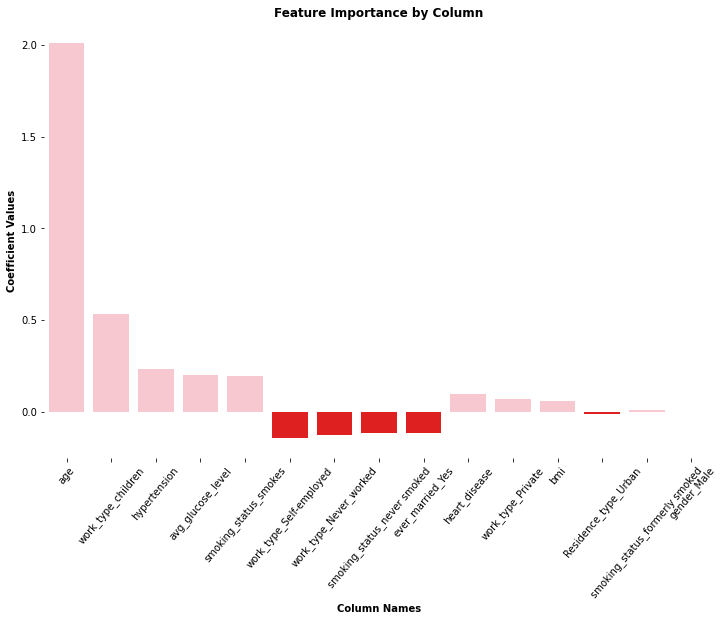

In [94]:
import seaborn as sns

x=feature_importance_df['Feature']
y=feature_importance_df['Coefficient']

fig, ax = plt.subplots(figsize=(12, 8))

colors = ['pink' if _y >=0 else 'red' for _y in y]
ax = sns.barplot(x, y, palette=colors)

ax.set_ylabel("Coefficient Values", fontweight='bold')
ax.set_xlabel("Column Names", fontweight='bold')
ax.set_title("Feature Importance by Column", fontweight='bold')
ax.tick_params (axis='x', labelrotation=50)

sns.despine(ax=ax, bottom=True, left=True)
plt.show()